
# Spectral analysis

Perform a full region based on-off spectral analysis and fit the resulting datasets.

## Prerequisites

-  Understanding how spectral extraction is performed in Cherenkov
   astronomy, in particular regarding OFF background measurements.
-  Understanding the basics data reduction and modeling/fitting process
   with the gammapy library API as shown in the :doc:`/tutorials/starting/analysis_2`
   tutorial.

## Context

While 3D analyses allow in principle to consider complex field of views
containing overlapping gamma-ray sources, in many cases we might have an
observation with a single, strong, point-like source in the field of
view. A spectral analysis, in that case, might consider all the events
inside a source (or ON) region and bin them in energy only, obtaining 1D
datasets.

In classical Cherenkov astronomy, the background estimation technique
associated with this method measures the number of events in OFF regions
taken in regions of the field-of-view devoid of gamma-ray emitters,
where the background rate is assumed to be equal to the one in the ON
region.

This allows to use a specific fit statistics for ON-OFF measurements,
the wstat (see `~gammapy.stats.wstat`), where no background model is
assumed. Background is treated as a set of nuisance parameters. This
removes some systematic effects connected to the choice or the quality
of the background model. But this comes at the expense of larger
statistical uncertainties on the fitted model parameters.

**Objective: perform a full region based spectral analysis of 4 Crab
observations of H.E.S.S. data release 1 and fit the resulting
datasets.**

## Introduction

Here, as usual, we use the `~gammapy.data.DataStore` to retrieve a
list of selected observations (`~gammapy.data.Observations`). Then, we
define the ON region containing the source and the geometry of the
`~gammapy.datasets.SpectrumDataset` object we want to produce. We then
create the corresponding dataset Maker.

We have to define the Maker object that will extract the OFF counts from
reflected regions in the field-of-view. To ensure we use data in an
energy range where the quality of the IRFs is good enough we also create
a safe range Maker.

We can then proceed with data reduction with a loop over all selected
observations to produce datasets in the relevant geometry.

We can then explore the resulting datasets and look at the cumulative
signal and significance of our source. We finally proceed with model
fitting.

In practice, we have to:

- Create a `~gammapy.data.DataStore` pointing to the relevant data
- Apply an observation selection to produce a list of observations,
  a `~gammapy.data.Observations` object.
- Define a geometry of the spectrum we want to produce:

  - Create a `~regions.CircleSkyRegion` for the ON extraction region
  - Create a `~gammapy.maps.MapAxis` for the energy binnings: one for the
    reconstructed (i.e.measured) energy, the other for the true energy
    (i.e.the one used by IRFs and models)

- Create the necessary makers :

  - the spectrum dataset maker : `~gammapy.makers.SpectrumDatasetMaker` -
    the OFF background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
  - and the safe range maker : `~gammapy.makers.SafeMaskMaker`

- Perform the data reduction loop. And for every observation:

  - Apply the makers sequentially to produce a `~gammapy.datasets.SpectrumDatasetOnOff`
  - Append it to list of datasets

- Define the `~gammapy.modeling.models.SkyModel` to apply to the dataset.
- Create a `~gammapy.modeling.Fit` object and run it to fit the model parameters
- Apply a `~gammapy.estimators.FluxPointsEstimator` to compute flux points for
  the spectral part of the fit.


In [86]:
from pathlib import Path

# Check package versions
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt

## Setup

As usual, we’ll start with some setup …




In [87]:
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    SkyModel,
    create_crab_spectral_model,
)

## Check setup



In [88]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.visualization import plot_spectrum_datasets_off_regions

check_tutorials_setup()


System:

	python_executable      : /Users/tharacaba/miniconda3/envs/gammapy-1.3/bin/python 
	python_version         : 3.11.11    
	machine                : arm64      
	system                 : Darwin     


Gammapy package:

	version                : 1.3        
	path                   : /Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy 


Other packages:

	numpy                  : 2.1.3      
	scipy                  : 1.14.1     
	astropy                : 6.1.6      
	regions                : 0.10       
	click                  : 8.1.8      
	yaml                   : 6.0.2      
	IPython                : 8.27.0     
	jupyterlab             : 4.2.7      
	matplotlib             : 3.9.4      
	pandas                 : 2.2.3      
	healpy                 : 1.18.0     
	iminuit                : 2.30.1     
	sherpa                 : not installed 
	naima                  : 0.10.2     
	emcee                  : 3.1.6      
	corner                 : 2.2.3   

## Load Data

First, we select and load some H.E.S.S. observations of the Crab nebula.

We will access the events, effective area, energy dispersion, livetime
and PSF for containment correction.




In [89]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
obs_ids = [23523, 23526, 23559, 23592]
observations = datastore.get_observations(obs_ids)

## Define Target Region

The next step is to define a signal extraction region, also known as on
region. In the simplest case this is just a
[CircleSkyRegion](http://astropy-regions.readthedocs.io/en/latest/api/regions.CircleSkyRegion.html)_.




In [90]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## Create exclusion mask

We will use the reflected regions method to place off regions to
estimate the background level in the on region. To make sure the off
regions don’t contain gamma-ray emission, we create an exclusion mask.

Using http://gamma-sky.net/ we find that there’s only one known
gamma-ray source near the Crab nebula: the AGN called [RGB
J0521+212](http://gamma-sky.net/#/cat/tev/23)_ at GLON = 183.604 deg
and GLAT = -8.708 deg.




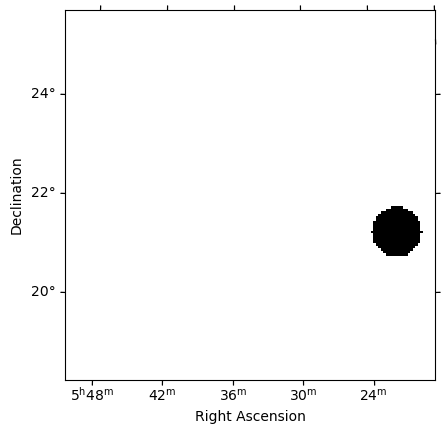

In [91]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

skydir = target_position.galactic
geom = WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot()
plt.show()

## Run data reduction chain

We begin with the configuration of the maker classes:




In [92]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)
safe_mask_maker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [93]:
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations):
    dataset = dataset_maker.run(dataset_empty.copy(name=str(obs_id)), observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_maker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

print(datasets)

Datasets
--------

Dataset 0: 

  Type       : SpectrumDatasetOnOff
  Name       : 23523
  Instrument : HESS
  Models     : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : 23526
  Instrument : HESS
  Models     : 

Dataset 2: 

  Type       : SpectrumDatasetOnOff
  Name       : 23559
  Instrument : HESS
  Models     : 

Dataset 3: 

  Type       : SpectrumDatasetOnOff
  Name       : 23592
  Instrument : HESS
  Models     : 




## Plot off regions




/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/regions/shapes/circle.py:160: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/Users/tharacaba/miniconda3/envs/gammapy-1.3/lib/python3.11/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


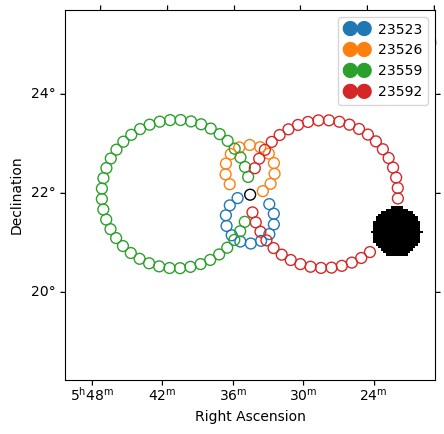

In [94]:
plt.figure()
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

## Source statistic

Next we’re going to look at the overall source statistics in our signal
region.




In [95]:
info_table = datasets.info_table(cumulative=True)

display(info_table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,149,139.25,20.449683569684254,9.75,20.461539024432028,20.461539024432028,nan,2892003.25,841726208.0,1581.736764695497,1687.0000000000016,0.09420025084179179,0.006164110373875637,0.08803614046791615,27,18,wstat,433.5372460592368,117,18.0,216.0,0.0833333358168602
stacked,303,280.75,28.446255766130005,22.250001907348633,43.84615575068094,43.84615575068094,nan,13397219.0,1572412928.0,3154.4235137812757,3369.9999999999964,0.09605558628263818,0.007053587386139242,0.08900199950115731,27,19,wstat,823.6909484036685,267,37.0,443.99993896484375,0.0833333432674408
stacked,439,408.7743835449219,36.17588855633591,30.225610733032227,50.88364497091608,50.88364497091608,nan,19239702.0,2077411712.0,4732.546993609518,5056.000000000001,0.09276188923063906,0.006386753427667313,0.08637513459388795,27,19,wstat,1325.2636829165463,594,56.0,1100.523681640625,0.05088486522436142
stacked,550,512.135498046875,40.90086300803346,37.864498138427734,59.674914380193016,59.674914380193016,nan,21017612.0,2635248128.0,6313.811659421768,6741.999999999996,0.08711061236349425,0.005997090217590596,0.08111352154172072,27,19,wstat,1701.2360501021876,869,74.0,1698.3189697265625,0.04357249662280083


And make the corresponding plots



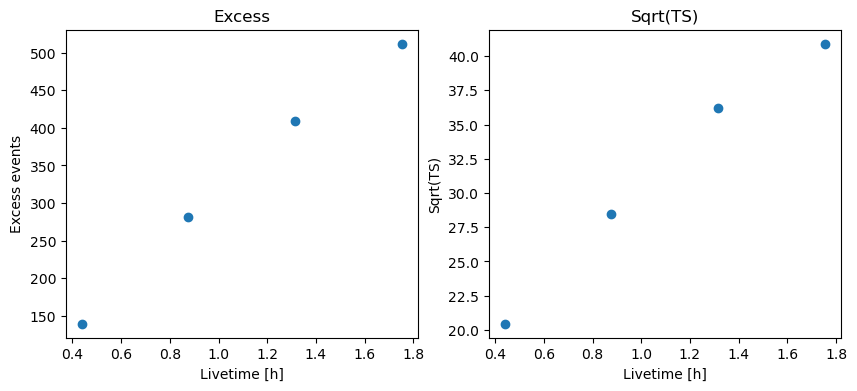

In [96]:
fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

Finally you can write the extracted datasets to disk using the OGIP
format (PHA, ARF, RMF, BKG, see
[here](https://gamma-astro-data-formats.readthedocs.io/en/latest/spectra/ogip/index.html)_
for details):




In [97]:
path = Path("spectrum_analysis")
path.mkdir(exist_ok=True)

for dataset in datasets:
    dataset.write(filename=path / f"obs_{dataset.name}.fits.gz", overwrite=True)

If you want to read back the datasets from disk you can use:




In [98]:
datasets = Datasets()

for obs_id in obs_ids:
    filename = path / f"obs_{obs_id}.fits.gz"
    datasets.append(SpectrumDatasetOnOff.read(filename))

## Fit spectrum

Now we’ll fit a global model to the spectrum. First we do a joint
likelihood fit to all observations. If you want to stack the
observations see below. We will also produce a debug plot in order to
show how the global fit matches one of the individual observations.




In [99]:
spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

## Fit quality and model residuals




We can access the results dictionary to see if the fit converged:




In [100]:
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 244
	total stat : 86.12

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



and check the best-fit parameters




In [101]:
display(result_joint.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,link,prior
str4,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
crab,,index,2.2727e+00,,1.566e-01,nan,nan,False,,
crab,,amplitude,4.7913e-11,TeV-1 s-1 cm-2,3.600e-12,nan,nan,False,,
crab,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,
crab,,lambda_,1.2097e-01,TeV-1,5.382e-02,nan,nan,False,,
crab,,alpha,1.0000e+00,,0.000e+00,nan,nan,True,,


A simple way to inspect the model residuals is using the function
`~SpectrumDataset.plot_fit()`




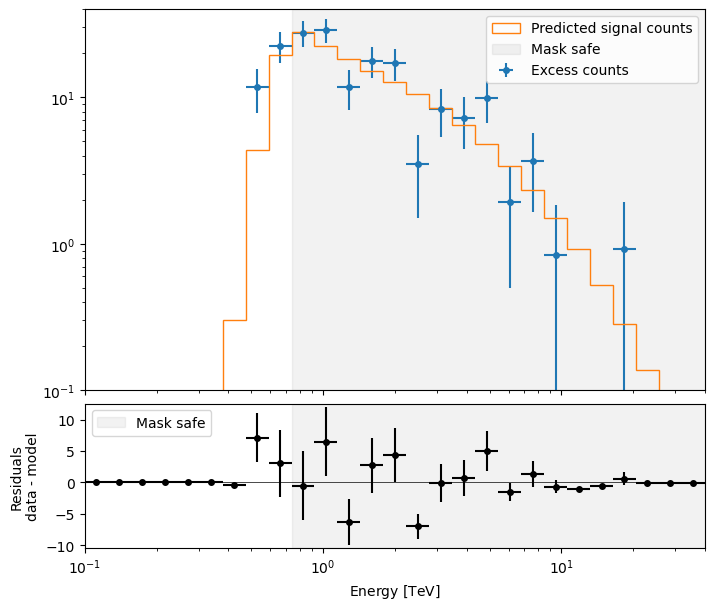

In [102]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 40)
plt.show()

For more ways of assessing fit quality, please refer to the dedicated
:doc:`/tutorials/api/fitting` tutorial.




## Compute Flux Points

To round up our analysis we can compute flux points by fitting the norm
of the global model in energy bands.
We create an instance of the
`~gammapy.estimators.FluxPointsEstimator`, by passing the dataset and
the energy binning:




In [103]:
fpe = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source="crab", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

Here is a the table of the resulting flux points:




In [104]:
display(flux_points.to_table(sed_type="dnde", formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[4],float32[4],float64,float64,float64[11],bool,float64[4],bool,float64[11]
0.112,0.100,0.125,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000
0.139,0.125,0.156,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000
0.174,0.156,0.195,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000
0.217,0.195,0.243,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000
0.271,0.243,0.303,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000
0.339,0.303,0.379,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000
0.423,0.379,0.473,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000
0.528,0.473,0.590,nan,nan,nan,nan,nan,nan,nan,nan .. nan,0.0 .. 0.0,0.000,0.000,nan .. nan,False,0.0 .. 0.0,False,0.200 .. 5.000


Now we plot the flux points and their likelihood profiles. For the
plotting of upper limits we choose a threshold of TS < 4.




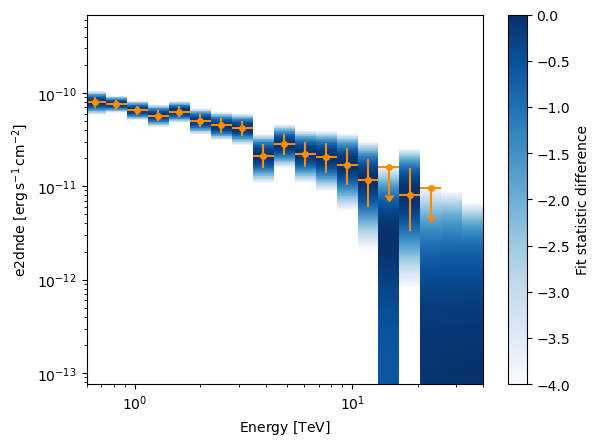

In [105]:
fig, ax = plt.subplots()
flux_points.plot(ax=ax, sed_type="e2dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
ax.set_xlim(0.6, 40)
plt.show()

Note: it is also possible to plot the flux distribution with the spectral model overlaid,
but you must ensure the axis binning is identical for the flux points and
integral flux.




The final plot with the best fit model, flux points and residuals can be
quickly made like this:




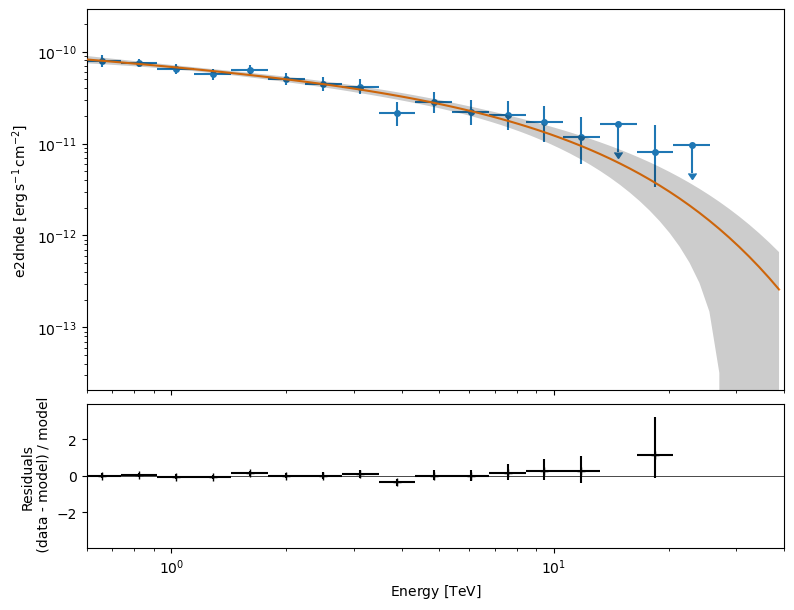

In [106]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint.copy()
)
ax, _ = flux_points_dataset.plot_fit()
ax.set_xlim(0.6, 40)
plt.show()

## Stack observations

An alternative approach to fitting the spectrum is stacking all
observations first and the fitting a model. For this we first stack the
individual datasets:




In [107]:
dataset_stacked = Datasets(datasets).stack_reduce()

Again we set the model on the dataset we would like to fit (in this case
it’s only a single one) and pass it to the `~gammapy.modeling.Fit`
object:




In [108]:
dataset_stacked.models = model
stacked_fit = Fit()
result_stacked = stacked_fit.run([dataset_stacked])

# Make a copy to compare later
model_best_stacked = model.copy()

print(result_stacked)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 54
	total stat : 8.16

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



And display the parameter table



In [109]:
display(model_best_joint.parameters.to_table())

display(model_best_stacked.parameters.to_table())

type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,index,2.2727e+00,,1.566e-01,nan,nan,False,,
,amplitude,4.7913e-11,TeV-1 s-1 cm-2,3.600e-12,nan,nan,False,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,
,lambda_,1.2097e-01,TeV-1,5.382e-02,nan,nan,False,,
,alpha,1.0000e+00,,0.000e+00,nan,nan,True,,


type,name,value,unit,error,min,max,frozen,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
,index,2.2785e+00,,1.563e-01,nan,nan,False,,
,amplitude,4.7800e-11,TeV-1 s-1 cm-2,3.566e-12,nan,nan,False,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,
,lambda_,1.1830e-01,TeV-1,5.329e-02,nan,nan,False,,
,alpha,1.0000e+00,,0.000e+00,nan,nan,True,,


Finally, we compare the results of our stacked analysis to a previously
published Crab Nebula Spectrum for reference. This is available in
`~gammapy.modeling.models.create_crab_spectral_model`.




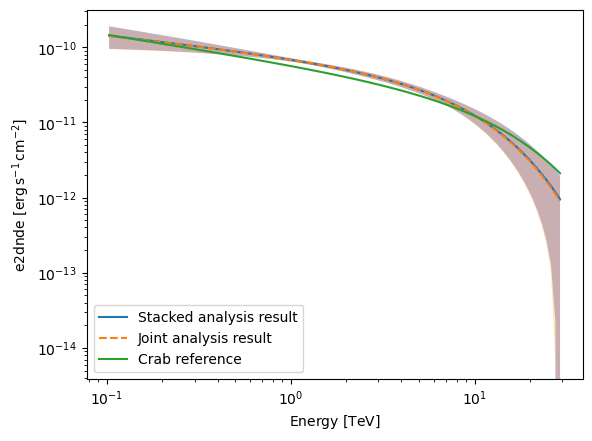

In [110]:
fig, ax = plt.subplots()

plot_kwargs = {
    "energy_bounds": [0.1, 30] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "ax": ax,
}

# plot stacked model
model_best_stacked.spectral_model.plot(**plot_kwargs, label="Stacked analysis result")
model_best_stacked.spectral_model.plot_error(facecolor="blue", alpha=0.3, **plot_kwargs)

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(facecolor="orange", alpha=0.3, **plot_kwargs)

create_crab_spectral_model("hess_ecpl").plot(
    **plot_kwargs,
    label="Crab reference",
)
ax.legend()
plt.show()

# sphinx_gallery_thumbnail_number = 5

## A note on statistics

Different statistic are available for the `~gammapy.datasets.FluxPointsDataset` :

- chi2 : estimate from chi2 statistics.
- profile : estimate from interpolation of the likelihood profile.
- distrib : estimate from probability distributions,
            assuming that flux points correspond to asymmetric gaussians
            and upper limits complementary error functions.

Default is `chi2`, in that case upper limits are ignored and the mean of asymetrics error is used.
So it is recommended to use `profile` if `stat_scan` is available on flux points.
The `distrib` case provides an approximation if the `profile` is not available
which allows to take into accounts upper limit and asymetrics error.

In the example below we can see that the `profile` case matches exactly the result
from the joint analysis of the ON/OFF datasets using `wstat` (as labelled).



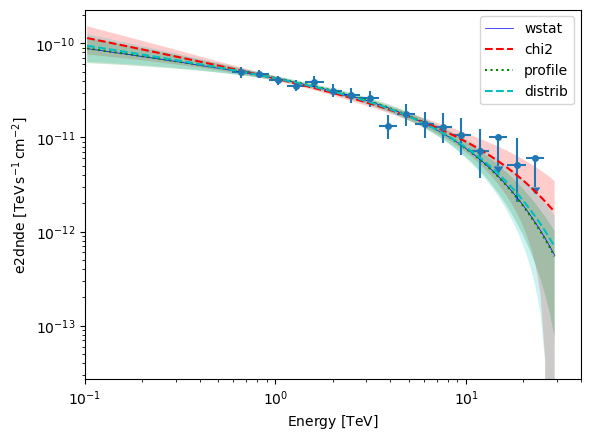

In [111]:
def plot_stat(fp_dataset):
    fig, ax = plt.subplots()

    plot_kwargs = {
        "energy_bounds": [0.1, 30] * u.TeV,
        "sed_type": "e2dnde",
        "ax": ax,
    }

    fp_dataset.data.plot(energy_power=2, ax=ax)
    model_best_joint.spectral_model.plot(
        color="b", lw=0.5, **plot_kwargs, label="wstat"
    )

    stat_types = ["chi2", "profile", "distrib"]
    colors = ["red", "g", "c"]
    lss = ["--", ":", "--"]

    for ks, stat in enumerate(stat_types):
        fp_dataset.stat_type = stat

        fit = Fit()
        fit.run([fp_dataset])

        fp_dataset.models[0].spectral_model.plot(
            color=colors[ks], ls=lss[ks], **plot_kwargs, label=stat
        )
        fp_dataset.models[0].spectral_model.plot_error(
            facecolor=colors[ks], **plot_kwargs
        )
        plt.legend()


plot_stat(flux_points_dataset)

In order to avoid discrepancies due to the treatment of upper limits
we can utilise the `~gammapy.estimators.utils.resample_energy_edges`
for defining energy bins in which the minimum number of `sqrt_ts` is 2.
In that case all the statistics definitions give equivalent results.




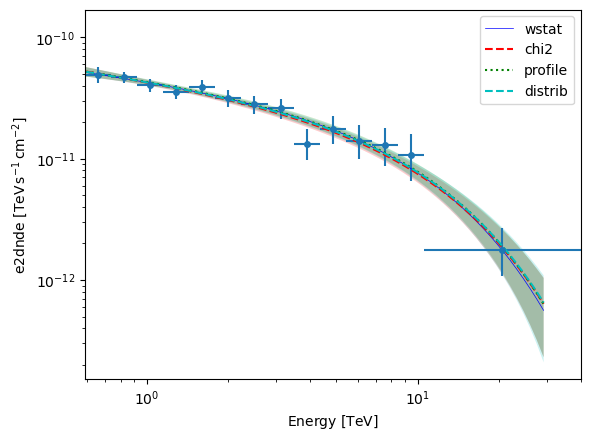

In [112]:
energy_edges = resample_energy_edges(dataset_stacked, conditions={"sqrt_ts_min": 2})

fpe_no_ul = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points_no_ul = fpe_no_ul.run(datasets=datasets)
flux_points_dataset_no_ul = FluxPointsDataset(
    data=flux_points_no_ul,
    models=model_best_joint.copy(),
)

plot_stat(flux_points_dataset_no_ul)

## Exercises

Now you have learned the basics of a spectral analysis with Gammapy. To
practice you can continue with the following exercises:

-  Fit a different spectral model to the data. You could try
   `~gammapy.modeling.models.ExpCutoffPowerLawSpectralModel` or
   `~gammapy.modeling.models.LogParabolaSpectralModel`.
-  Compute flux points for the stacked dataset.
-  Create a `~gammapy.datasets.FluxPointsDataset` with the flux points
   you have computed for the stacked dataset and fit the flux points
   again with obe of the spectral models. How does the result compare to
   the best fit model, that was directly fitted to the counts data?




In [113]:
from gammapy.modeling.models import (
    LogParabolaSpectralModel
)

spectral_model = LogParabolaSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit_joint = Fit()
result_joint = fit_joint.run(datasets=datasets)

# we make a copy here to compare it later
model_best_joint = model.copy()

print(result_joint)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 230
	total stat : 87.01

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [114]:
display(result_joint.models.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,link,prior
str4,str1,str9,float64,str14,float64,float64,float64,bool,str1,str1
crab,,amplitude,4.3611e-11,TeV-1 s-1 cm-2,2.330e-12,nan,nan,False,,
crab,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,,
crab,,alpha,2.3145e+00,,1.400e-01,nan,nan,False,,
crab,,beta,2.0053e-01,,8.201e-02,nan,nan,False,,


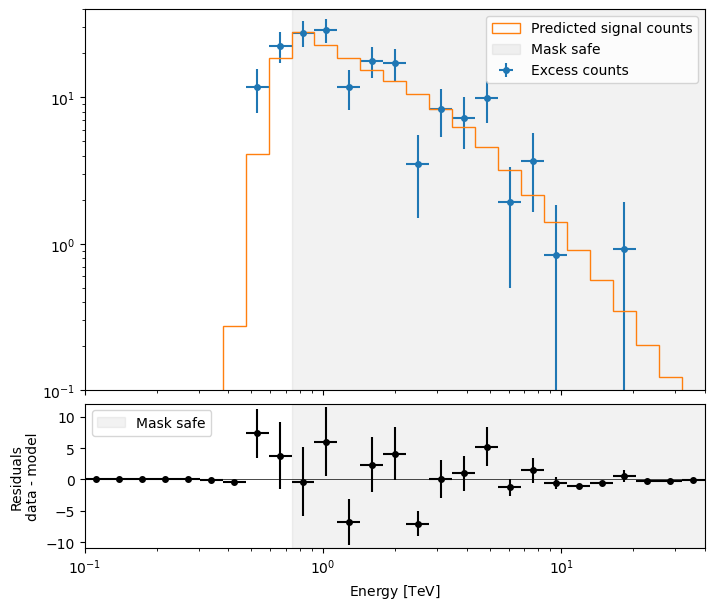

In [115]:
ax_spectrum, ax_residuals = datasets[0].plot_fit()
ax_spectrum.set_ylim(0.1, 40)
plt.show()

In [116]:
fpe = FluxPointsEstimator(
    energy_edges=energy_axis.edges, source="crab", selection_optional="all"
)
flux_points = fpe.run(datasets=dataset_stacked)

display(flux_points.to_table(sed_type="dnde", formatted=True))

e_ref,e_min,e_max,dnde,dnde_err,dnde_errp,dnde_errn,dnde_ul,ts,sqrt_ts,npred,npred_excess,stat,stat_null,stat_scan,is_ul,counts,success,norm_scan
TeV,TeV,TeV,1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),1 / (TeV s cm2),,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[1],float32[1],float64,float64,float64[11],bool,float64[1],bool,float64[11]
0.112,0.100,0.125,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000
0.139,0.125,0.156,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000
0.174,0.156,0.195,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000
0.217,0.195,0.243,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000
0.271,0.243,0.303,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000
0.339,0.303,0.379,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000
0.423,0.379,0.473,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000
0.528,0.473,0.590,nan,nan,nan,nan,nan,nan,nan,nan,0.0,0.000,0.000,nan .. nan,False,0.0,False,0.200 .. 5.000


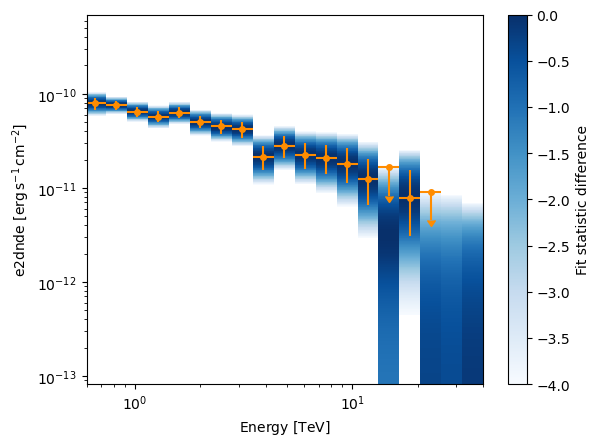

In [117]:
fig, ax = plt.subplots()
flux_points.plot(ax=ax, sed_type="e2dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")
ax.set_xlim(0.6, 40)
plt.show()

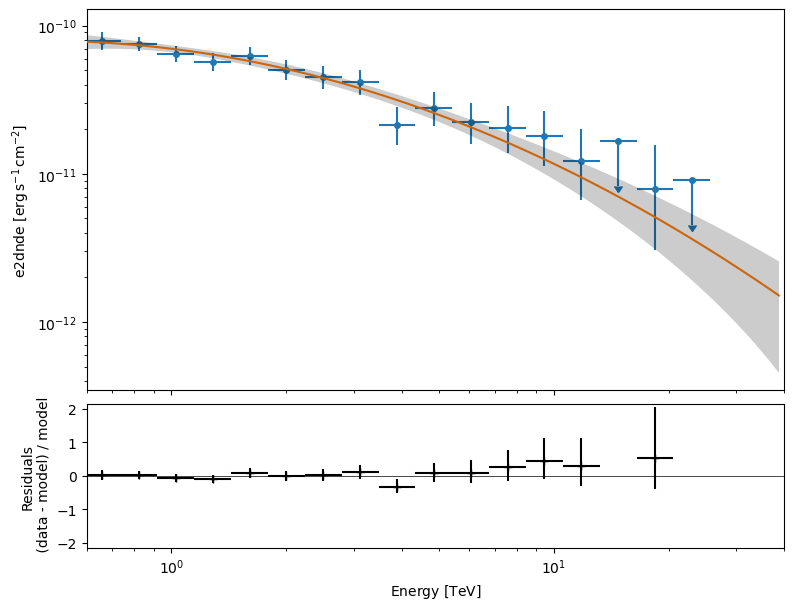

In [118]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint.copy()
)
ax, _ = flux_points_dataset.plot_fit()
ax.set_xlim(0.6, 40)
plt.show()

## What next?

The methods shown in this tutorial is valid for point-like or midly
extended sources where we can assume that the IRF taken at the region
center is valid over the whole region. If one wants to extract the 1D
spectrum of a large source and properly average the response over the
extraction region, one has to use a different approach explained in
the :doc:`/tutorials/analysis-1d/extended_source_spectral_analysis`
tutorial.


